In [2]:
import numpy as np 
import nibabel as nib 
import matplotlib.pyplot as plt 
import nilearn.plotting as niplt
%matplotlib inline
import os 

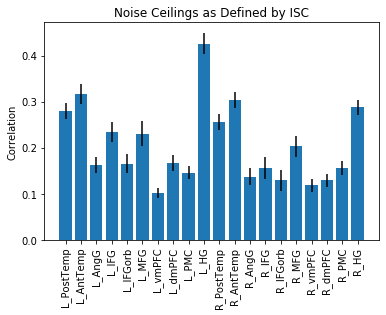

In [43]:
#View ISC Results
results=[]
dataset=['black','slumlordreach']
for story in dataset:
    results_story=[]
    if story=='black':
        subs=black_subs
    if story=='slumlordreach':
        subs=slumlordreach_subs
    roi_mapping=np.load('/jukebox/griffiths/bert-brains/'+story+'_data/Parcel2ROI.npy')
    for sub in subs:
        results_sub_parcels=np.load('/jukebox/griffiths/bert-brains/'+story+"_data/isc/"+sub+'.npy')
        results_sub=np.zeros((20,))
        for roi in range(20):
            results_sub[roi]=results_sub_parcels[np.where(roi_mapping==roi+1)].mean() 
        results_story.append(results_sub)
    results_story=np.asarray(results_story)
    results.append(results_story)
results=np.asarray(results)
isc_results=np.concatenate(results,axis=0)
errors=np.asarray([bootstrap_errors(isc_results[:,i]) for i in range(isc_results.shape[1])])
plt.bar(list(range(20)),isc_results.mean(axis=0),yerr=errors.T)
plt.xticks(list(range(20)),roi_names,rotation=90)
plt.ylabel("Correlation")
plt.title("Noise Ceilings as Defined by ISC")

noise_ceiling=isc_results.mean(axis=0)


In [41]:
black_subs=['sub-300', 'sub-304', 'sub-293', 'sub-273', 'sub-265', 'sub-307', 'sub-283', 'sub-275', 
'sub-291', 'sub-297', 'sub-303', 'sub-294', 'sub-286', 'sub-282', 'sub-310', 'sub-302', 'sub-312', 
'sub-301', 'sub-287', 'sub-298', 'sub-313', 'sub-285', 'sub-292', 'sub-311', 'sub-267', 'sub-295', 
'sub-305', 'sub-274', 'sub-290', 'sub-288', 'sub-281', 'sub-276', 'sub-277', 'sub-299', 'sub-308',
 'sub-272', 'sub-284', 'sub-289', 'sub-280', 'sub-309', 'sub-306', 'sub-296', 'sub-127', 'sub-279', 
 'sub-315', 'sub-314']
slumlordreach_subs=['sub-145', 'sub-143', 'sub-016', 'sub-142', 'sub-141', 'sub-133', 'sub-140', 'sub-136', 
'sub-084', 'sub-135', 'sub-137', 'sub-138', 'sub-111', 'sub-106', 'sub-134', 'sub-132', 'sub-144']

rois=['PostTemp','AntTemp','AngG','IFG','IFGorb','MFG','vmPFC','dmPFC','PMC','HG']
roi_names=['L_'+roi for roi in rois]+['R_'+roi for roi in rois] 

def permutation_t_test(data1,data2): 
    diff=data1-data2
    stderr=np.std(diff,ddof=1)/np.sqrt(len(diff))+1e-9
    original_t=np.mean(diff)/stderr
    permutations=[]
    flip_diff=diff.copy()
    for _ in range(10000):
        flip_idxs=np.random.choice([0,1],size=len(diff),replace=True).astype('bool')
        flip_diff[flip_idxs]=diff[flip_idxs]*-1
        flip_diff[~flip_idxs]=diff[~flip_idxs]  
        flip_stderr=np.std(flip_diff,ddof=1)/np.sqrt(len(flip_diff))+1e-9 
        permutations.append(np.mean(flip_diff)/flip_stderr)
    permutations=np.asarray(permutations)

    if original_t<0:
        p_value=float(np.sum(permutations<=original_t))/len(permutations)
    else:
        p_value=float(np.sum(permutations>=original_t))/len(permutations)
    return original_t,p_value



def get_result_dataset(dataset,rep_name,normalize_isc=False):
    results=[]
    for story in dataset:
        results_story=[]
        if story=='black':
            subs=black_subs
        if story=='slumlordreach':
            subs=slumlordreach_subs
        if 'layer' not in rep_name:
            result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding-"+story+"_"+rep_name+"/"
        else:
            result_dir='/jukebox/griffiths/bert-brains/results/'+story+"/encoding-"+rep_name+"/"
        roi_mapping=np.load('/jukebox/griffiths/bert-brains/'+story+'_data/Parcel2ROI.npy')
        for sub in subs:
            results_sub_parcels=np.load(result_dir+sub+"_parcelwise_results.npy")
            results_sub=np.zeros((20,))
            for roi in range(20):
                results_sub[roi]=results_sub_parcels[np.where(roi_mapping==roi+1)].mean() 
            results_story.append(results_sub)
        results_story=np.asarray(results_story)
        results.append(results_story)
    results=np.asarray(results)
    if normalize_isc:
        return (np.concatenate(results,axis=0)/noise_ceiling)*100.0
    else:
        return np.concatenate(results,axis=0)
            

def bootstrap_errors(data):
    mean=data.mean()
    sampling=[]
    for _ in range(10000):
        sampling.append(np.mean(np.random.choice(data,size=len(data),replace=True)))
    sampling=np.asarray(sampling)
    ci=np.percentile(sampling,[2.5,97.5])
    return np.abs(ci-mean)

def barplot(dataset,rep_names,normalize_isc=False):
    barWidth=0.8/len(rep_names)
    for r_idx,rep_name in enumerate(rep_names):
        results=get_result_dataset(dataset,rep_name,normalize_isc=normalize_isc)
        errors=np.asarray([bootstrap_errors(results[:,i]) for i in range(results.shape[1])])
        print(results.max())
        plt.bar([i+(r_idx*barWidth) for i in range(20)],results.mean(axis=0),yerr=errors.T,width=barWidth)
    if 'layer' not in rep_names[0]:
        plt.legend([r[18:] for r in rep_names])
    else:
        plt.legend(rep_names)
    plt.xticks(list(range(20)),roi_names,rotation=90)
    if len(dataset)==2:
        story_name='Combined Storys'
    else:
        story_name=dataset[0]
    plt.title(story_name)
    plt.ylabel("Pearson's R")

def p_adjust_bh(p):
    """Benjamini-Hochberg p-value correction for multiple hypothesis testing."""
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig] 

def comparison_barplot(dataset,rep_names):
    barWidth=0.8 
    results1=get_result_dataset(dataset,rep_names[0])
    results2=get_result_dataset(dataset,rep_names[1])
    perm_results=np.asarray([permutation_t_test(results1[:,i],results2[:,i]) for i in range(20)])
    t_values=perm_results[:,0]
    p_values=p_adjust_bh(perm_results[:,1])
    t_values[p_values>0.05]=0.0
    results=t_values.copy()
    #errors=np.asarray([bootstrap_errors(results[:,i]) for i in range(results.shape[1])])
    plt.bar([i for i in range(20)],results,width=barWidth)
    if len(dataset)==2:
        story_name='Combined Storys'
    else:
        story_name=dataset[0]
    plt.xticks(list(range(20)),roi_names,rotation=90)
    plt.title(rep_names[0]+" vs "+rep_names[1]+" / "+story_name)
    plt.ylabel("Pearson's R")



In [3]:
fnames=os.listdir('/jukebox/griffiths/bert-brains/code/bert-brains/data/black/bert-base-uncased/syntactic_analyses/')
dataset=['black','slumlordreach']
reps=[rep[6:-4] for rep in fnames]
reps 

['bert-base-uncased_semantic_composition_20-TRs',
 'bert-base-uncased_semantic_composition_0-TRs',
 'bert-base-uncased_syntactic_complexity_L-inf_T-20_D-concat',
 'bert-base-uncased_semantic_composition_1-TRs',
 'bert-base-uncased_syntactic_complexity_L-1_T-128_D-concat',
 'bert-base-uncased_syntactic_distance_T-128_D-bck',
 'bert-base-uncased_syntactic_complexity_L-inf_T-10_D-bck',
 'bert-base-uncased_syntactic_complexity_L-inf_T-10_D-concat',
 'bert-base-uncased_semantic_composition_5-TRs',
 'bert-base-uncased_syntactic_complexity_L-1_T-20_D-fwd',
 'bert-base-uncased_syntactic_distance_T-10_D-fwd',
 'bert-base-uncased_syntactic_complexity_L-inf_T-20_D-bck',
 'bert-base-uncased_syntactic_complexity_L-1_T-128_D-fwd',
 'bert-base-uncased_syntactic_complexity_L-1_T-10_D-concat',
 'bert-base-uncased_semantic_composition_2-TRs',
 'bert-base-uncased_semantic_composition_10-TRs',
 'bert-base-uncased_syntactic_distance_T-128_D-concat',
 'bert-base-uncased_syntactic_complexity_L-1_T-10_D-fwd',

/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


0.40277439517775154


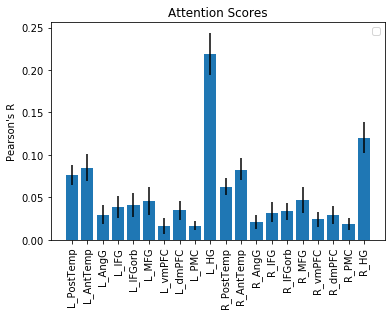

In [4]:
barplot(['slumlordreach','black'],['bert-base-uncased_syntactic_complexity_L-inf_T-128_D-concat'])
plt.title("Attention Scores")
plt.legend([])

0.18428891062200278
0.28648600159529264
0.2117824507654191
0.20916004298598073
0.3198564156323516
0.18535917533226226
0.3224865389801628
0.21017841532760398
0.317882205574773
0.21720061864462842
0.31234165235078787
0.25655734673899366
0.30222766256592726
0.2609465648640064
0.2846867246091966
0.2750457475093879
0.30061621399180277
0.26562974039748066
0.2898759596126135
0.2680544916955335
0.3008647485598552
0.23819324345971576
0.27315552048109215
0.22270074318586053


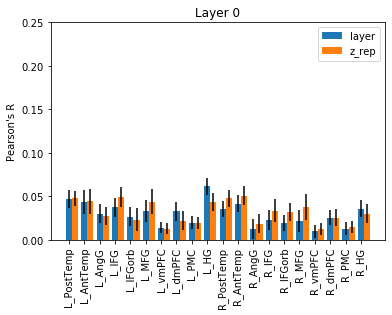

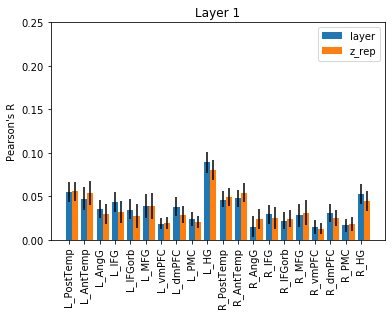

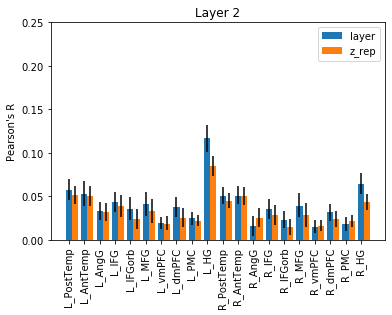

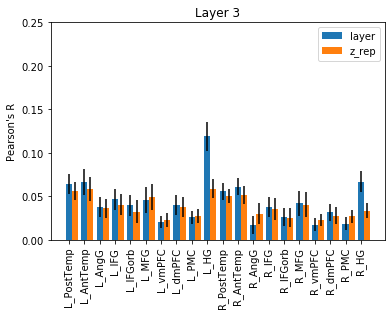

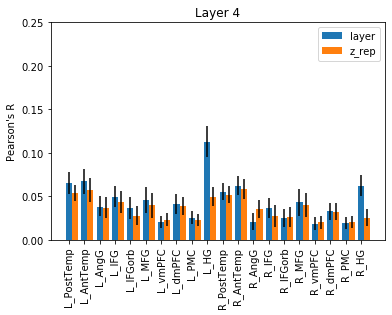

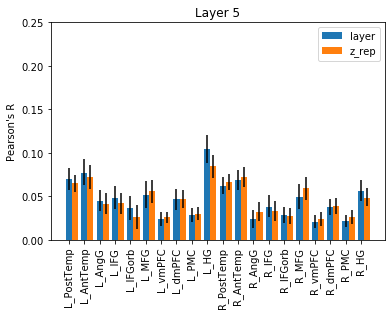

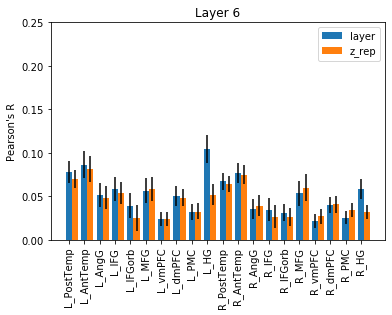

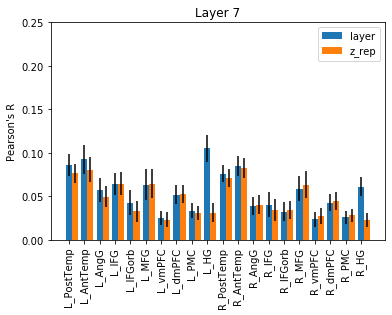

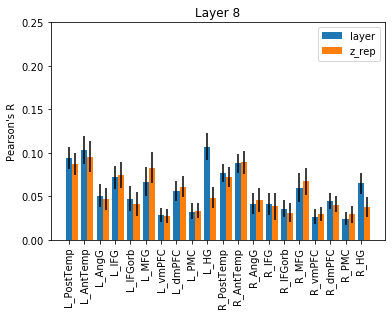

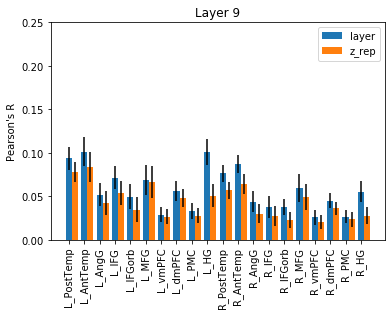

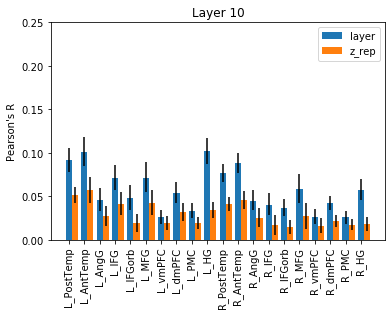

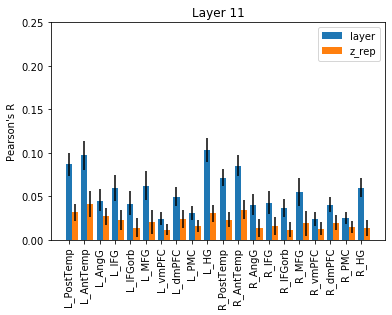

In [5]:
dataset=['black','slumlordreach']
for i in range(12):
    plt.figure() 
    barplot(dataset,['layer_'+str(i+1)+"_activations",'layer_'+str(i)+"_z_representations"])
    plt.title("Layer "+str(i))
    plt.legend(['layer','z_rep'])
    plt.ylim(0,0.25)

/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
(13, 20)


Text(0.5, 1.0, 'Layer Reps')

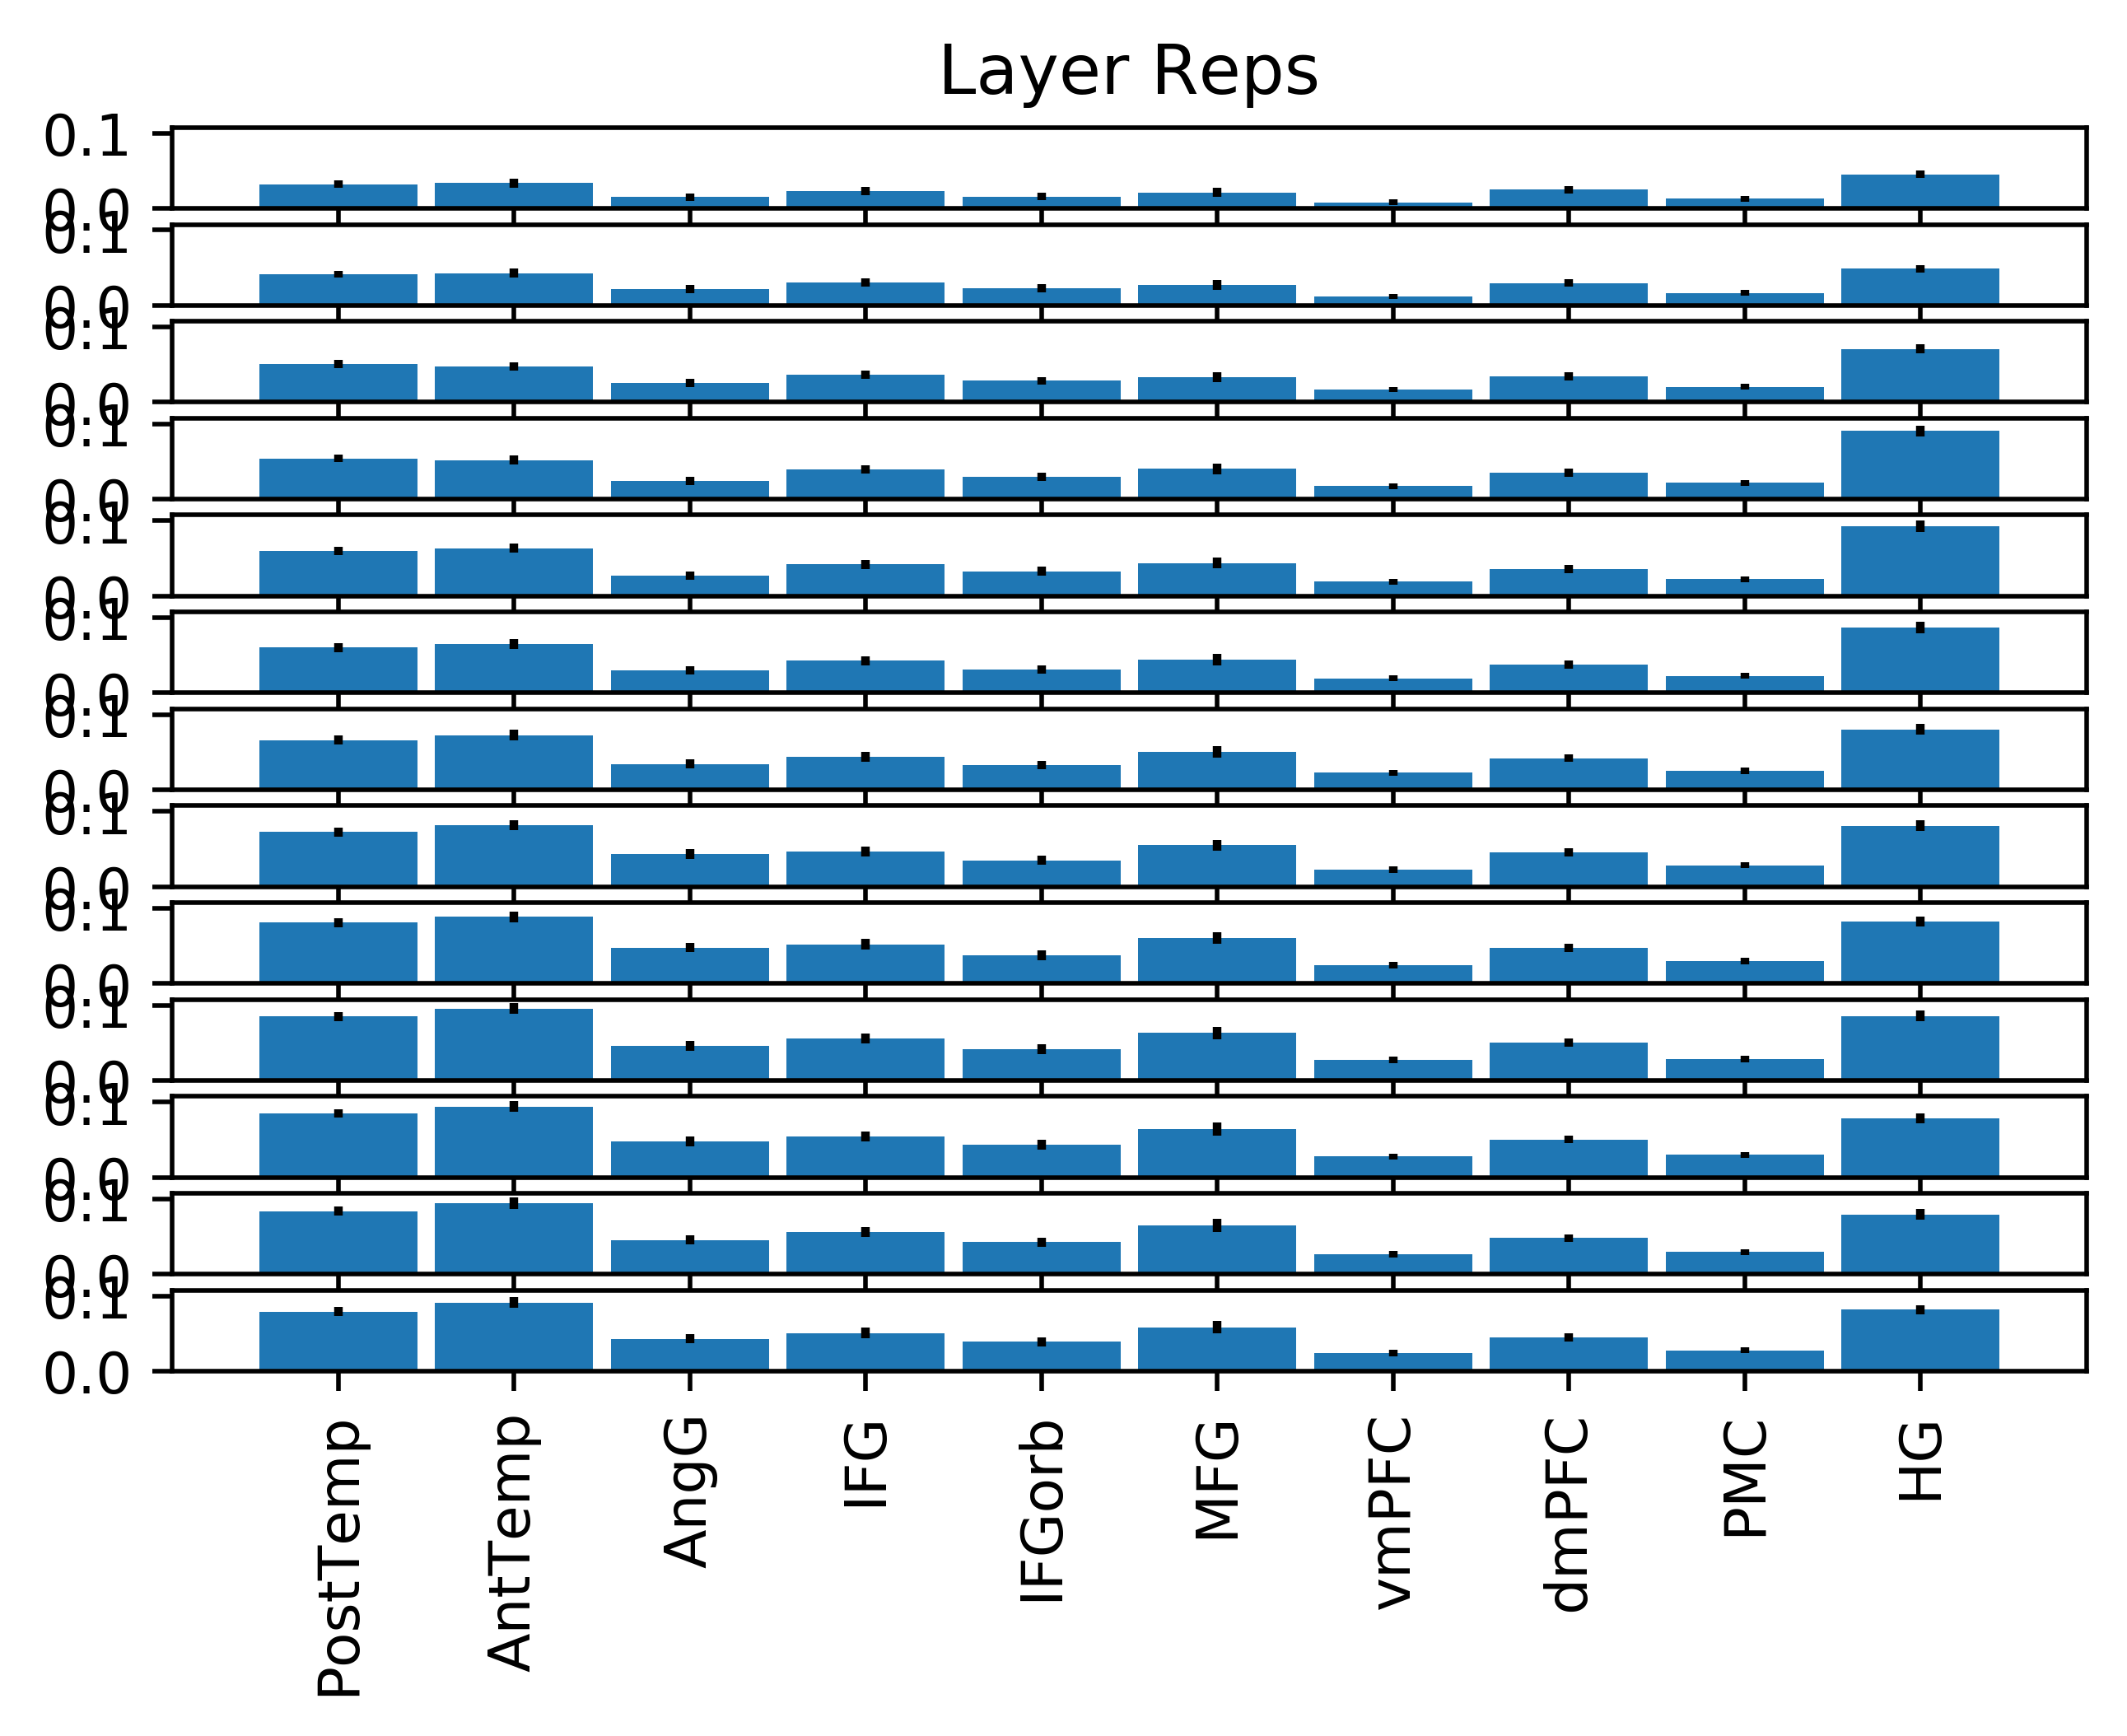

In [14]:
z_reps=['layer_'+str(i)+"_z_representations" for i in range(12)]
layer_reps=['layer_'+str(i)+"_activations" for i in range(13)]
layer_reps_mat=np.asarray([get_result_dataset(['black','slumlordreach'],layer_reps[i]) for i in range(13)]).mean(axis=1)
errors=np.asarray([get_result_dataset(['black','slumlordreach'],layer_reps[i]) for i in range(13)]).std(axis=1)/np.sqrt(63)
print(layer_reps_mat.shape)
layer_reps_mat=np.asarray([layer_reps_mat[:,:10],layer_reps_mat[:,10:]]).mean(axis=0)
errors=np.asarray([errors[:,:10],errors[:,10:]]).mean(axis=0)
fig,axarr=plt.subplots(nrows=13,sharex=True,sharey=True,dpi=500)
for i in range(13):
    axarr[i].bar(list(range(10)),layer_reps_mat[i],width=0.9,yerr=errors[i])
    axarr[i].set_xticks(list(range(10)))
    axarr[i].set_xticklabels(rois,rotation=90)
    #axarr[i].set_yticklabels([])
    #axarr[i].set_title(rois[i])
#fig.tight_layout()
axarr[0].set_title("Layer Reps")

/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
(12, 20)


Text(0.5, 1.0, 'Z Reps')

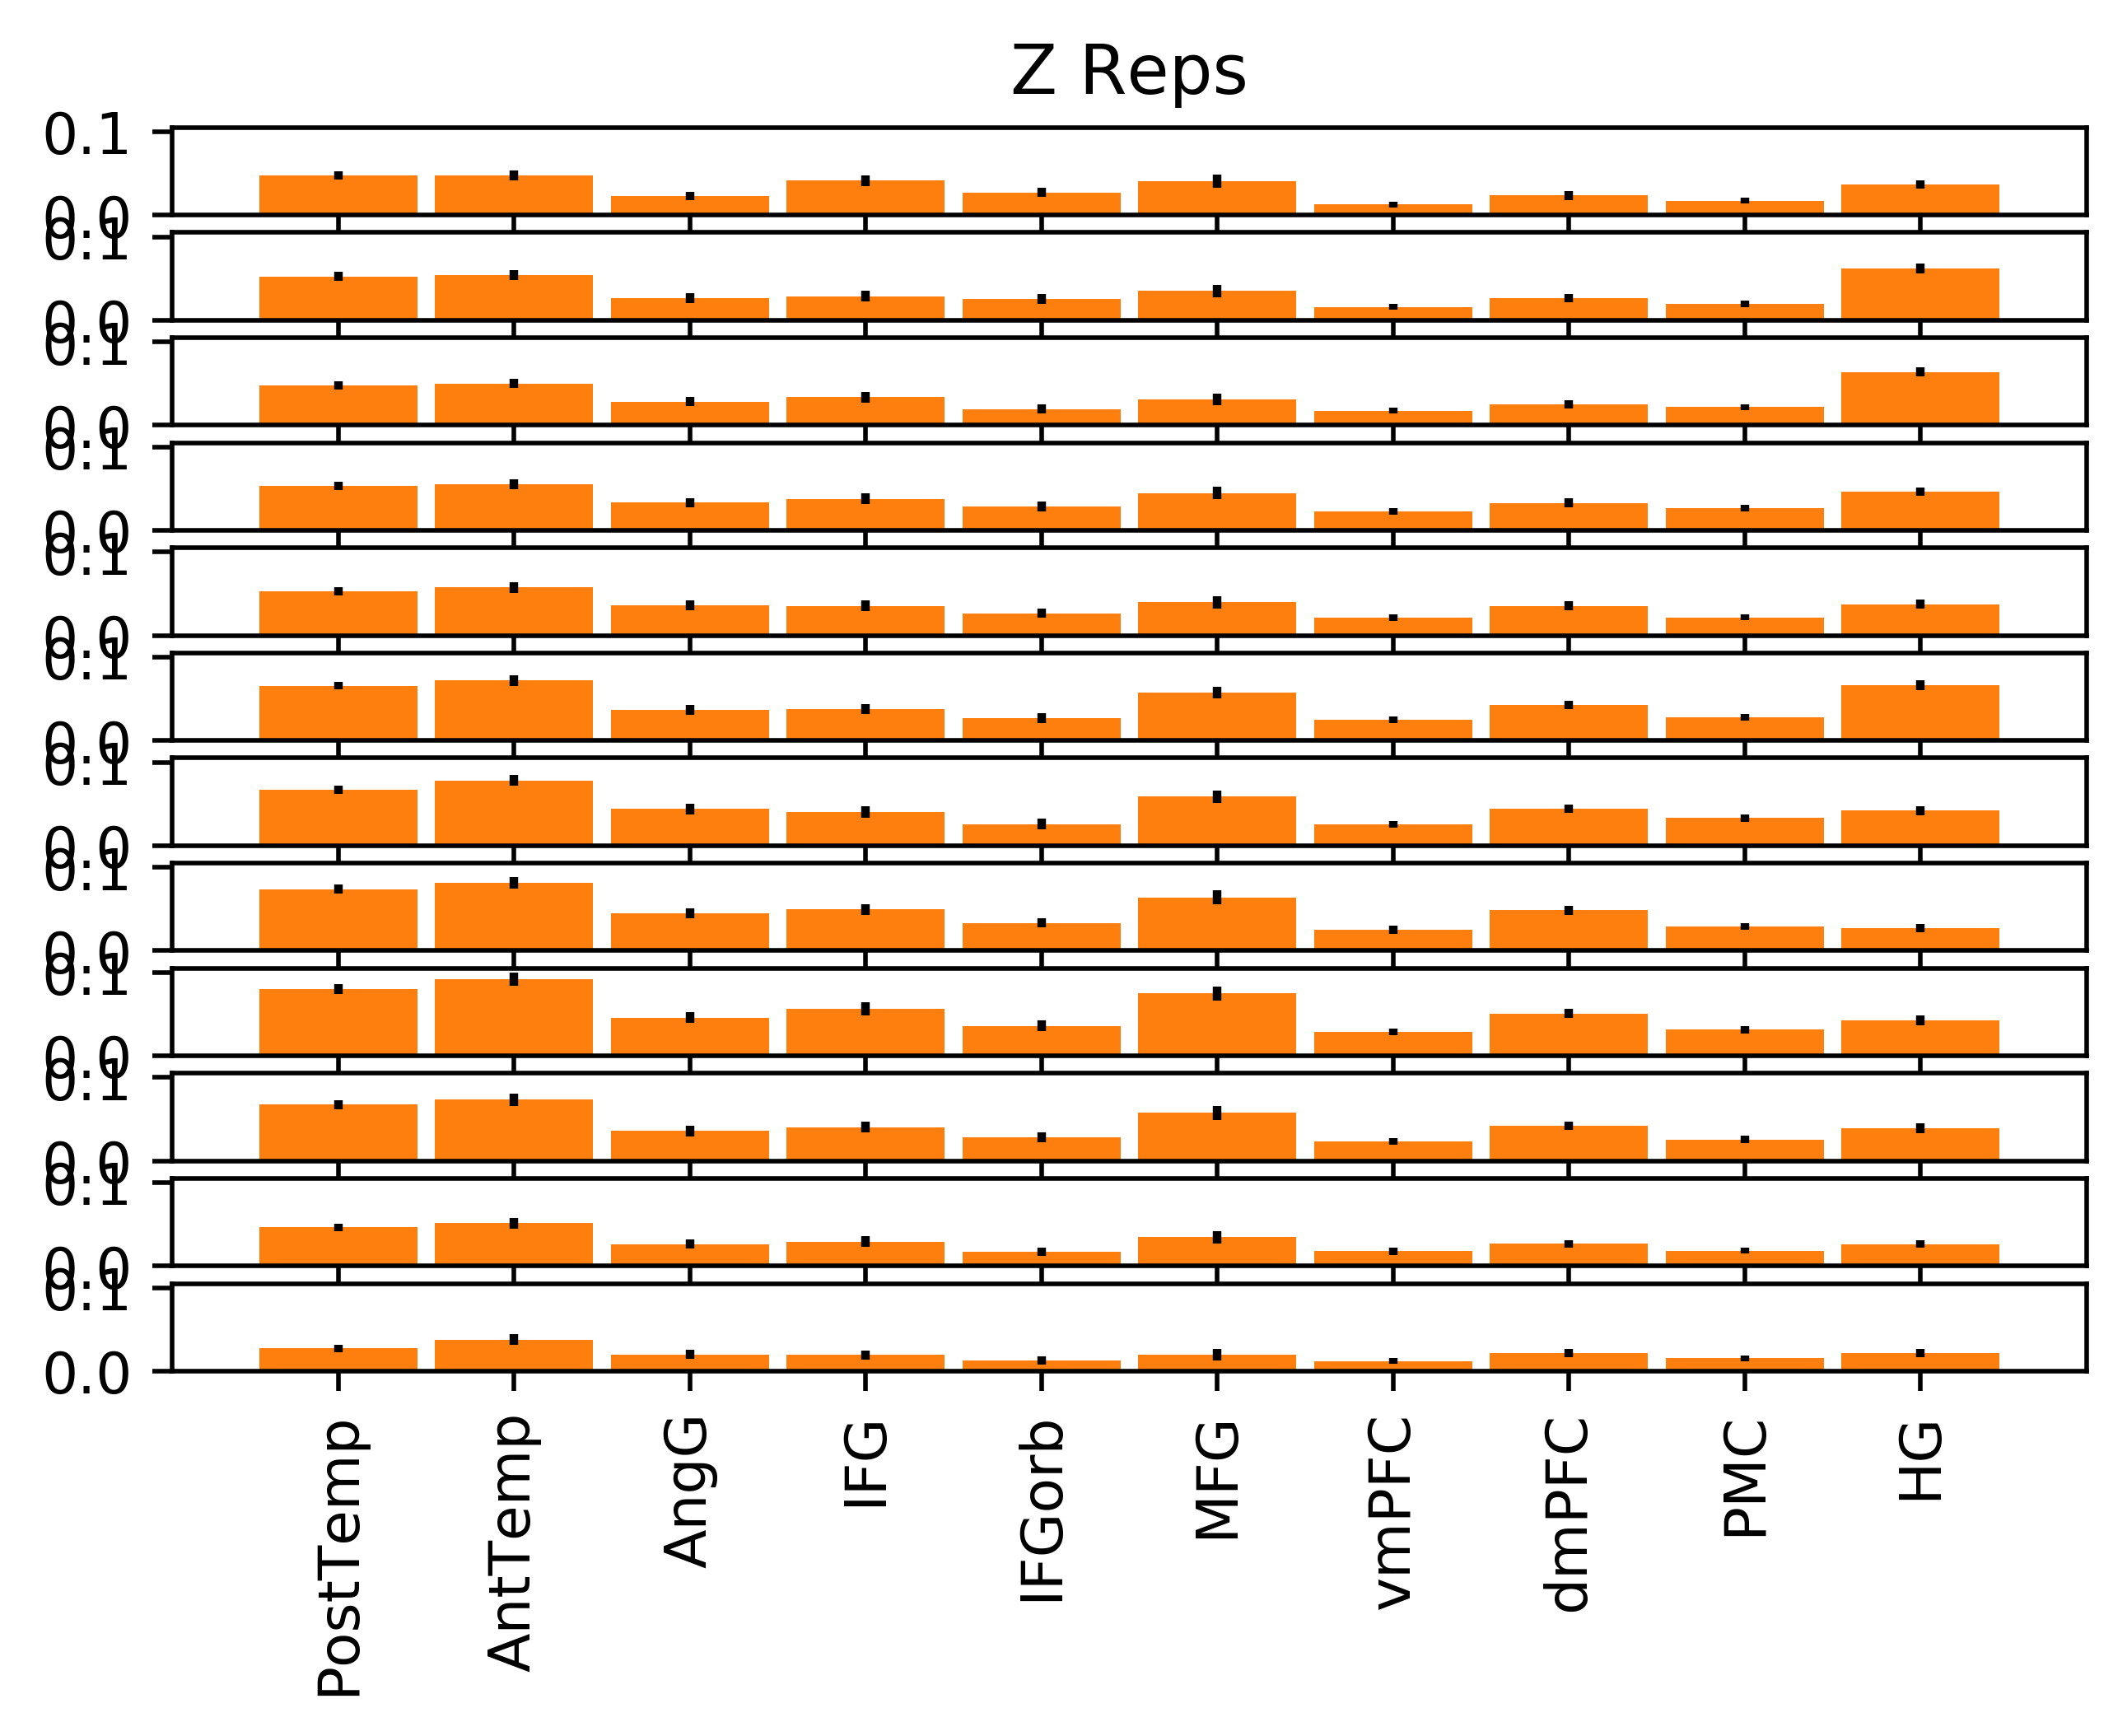

In [20]:
z_reps=['layer_'+str(i)+"_z_representations" for i in range(12)]
layer_reps=['layer_'+str(i)+"_activations" for i in range(13)]
layer_reps_mat=np.asarray([get_result_dataset(['black','slumlordreach'],z_reps[i]) for i in range(12)]).mean(axis=1)
errors=np.asarray([get_result_dataset(['black','slumlordreach'],z_reps[i]) for i in range(12)]).std(axis=1)/np.sqrt(63)
print(layer_reps_mat.shape)
layer_reps_mat=np.asarray([layer_reps_mat[:,:10],layer_reps_mat[:,10:]]).mean(axis=0)
errors=np.asarray([errors[:,:10],errors[:,10:]]).mean(axis=0)
fig,axarr=plt.subplots(nrows=12,sharex=True,sharey=True,dpi=500)
for i in range(12):
    axarr[i].bar(list(range(10)),layer_reps_mat[i],width=0.9,yerr=errors[i],color='C1')
    axarr[i].set_xticks(list(range(10)))
    axarr[i].set_xticklabels(rois,rotation=90)
    #axarr[i].set_yticklabels([])
    #axarr[i].set_title(rois[i])
#fig.tight_layout()
axarr[0].set_title("Z Reps")

139.3772763857449


Text(0, 0.5, 'Percent of Noise Ceiling')

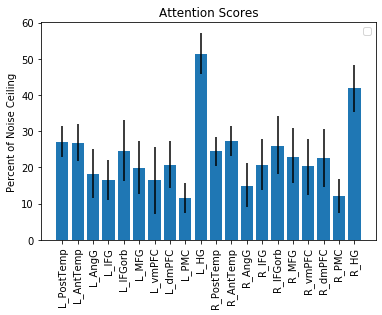

In [44]:
#From this cell onward I am normalizing by the ISC noise ceiling. 

barplot(['slumlordreach','black'],['bert-base-uncased_syntactic_complexity_L-inf_T-128_D-concat'],normalize_isc=True)
plt.title("Attention Scores")
plt.legend([])
plt.ylabel("Percent of Noise Ceiling")

115.1441166756521
131.10343917998358
108.76774358985948
127.37977549132995
122.45326343675053
105.76456359582751
119.64631422065177
130.7769469109774
124.35986153456918
134.27768405591075
136.17077895356806
126.57170521529689
155.553032593615
153.9701648841629
162.9387720646394
129.84282984019896
163.08558017457858
181.79805831885508
163.19007085818433
158.03321371071385
160.84975579401763
117.2079612711152
154.88721485241365
103.1897566479007


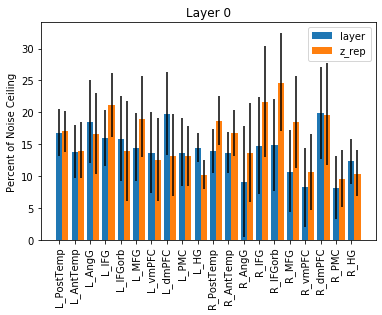

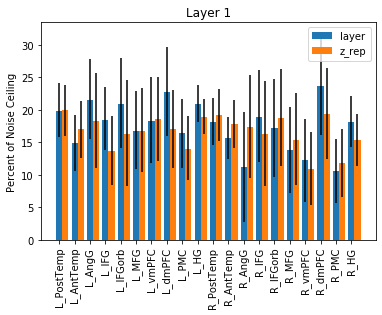

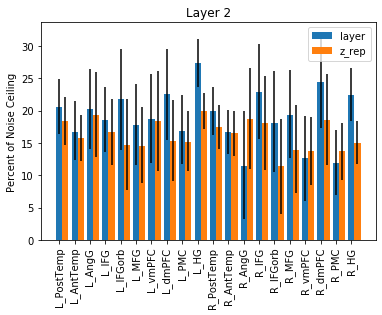

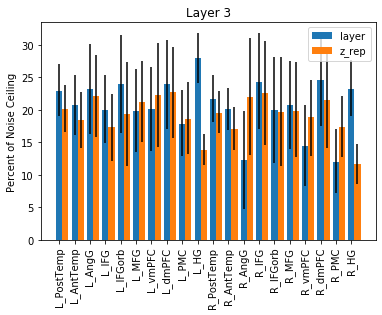

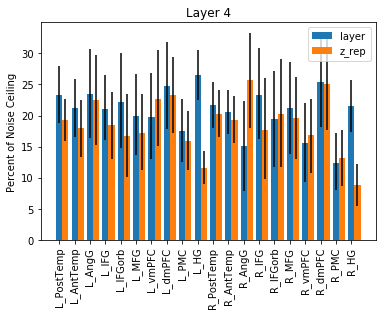

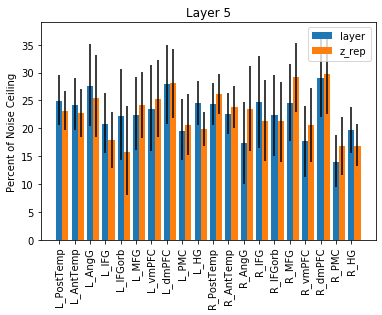

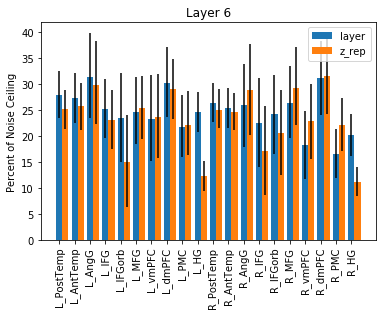

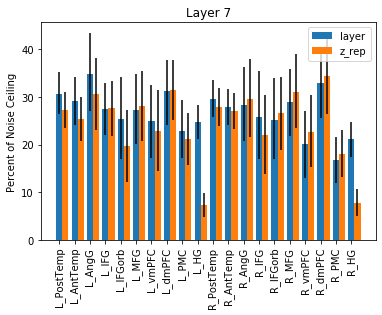

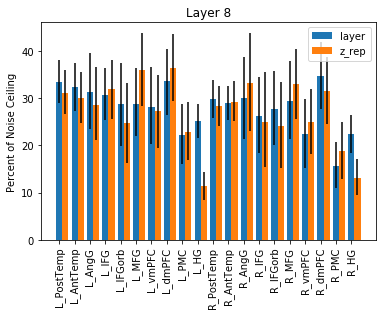

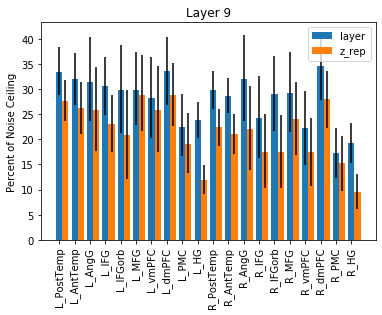

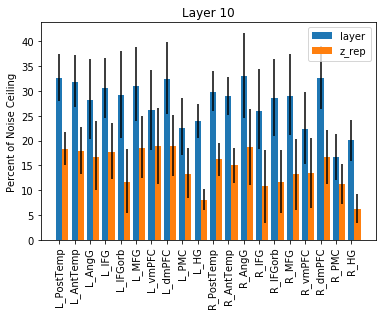

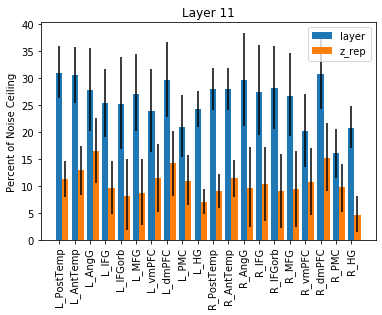

In [45]:
dataset=['black','slumlordreach']
for i in range(12):
    plt.figure() 
    barplot(dataset,['layer_'+str(i+1)+"_activations",'layer_'+str(i)+"_z_representations"],normalize_isc=True)
    plt.title("Layer "+str(i))
    plt.legend(['layer','z_rep'])
    plt.ylabel("Percent of Noise Ceiling")
    plt.ylim(0,40.0)

/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
(13, 20)


Text(0.5, 1.0, 'Layer Reps')

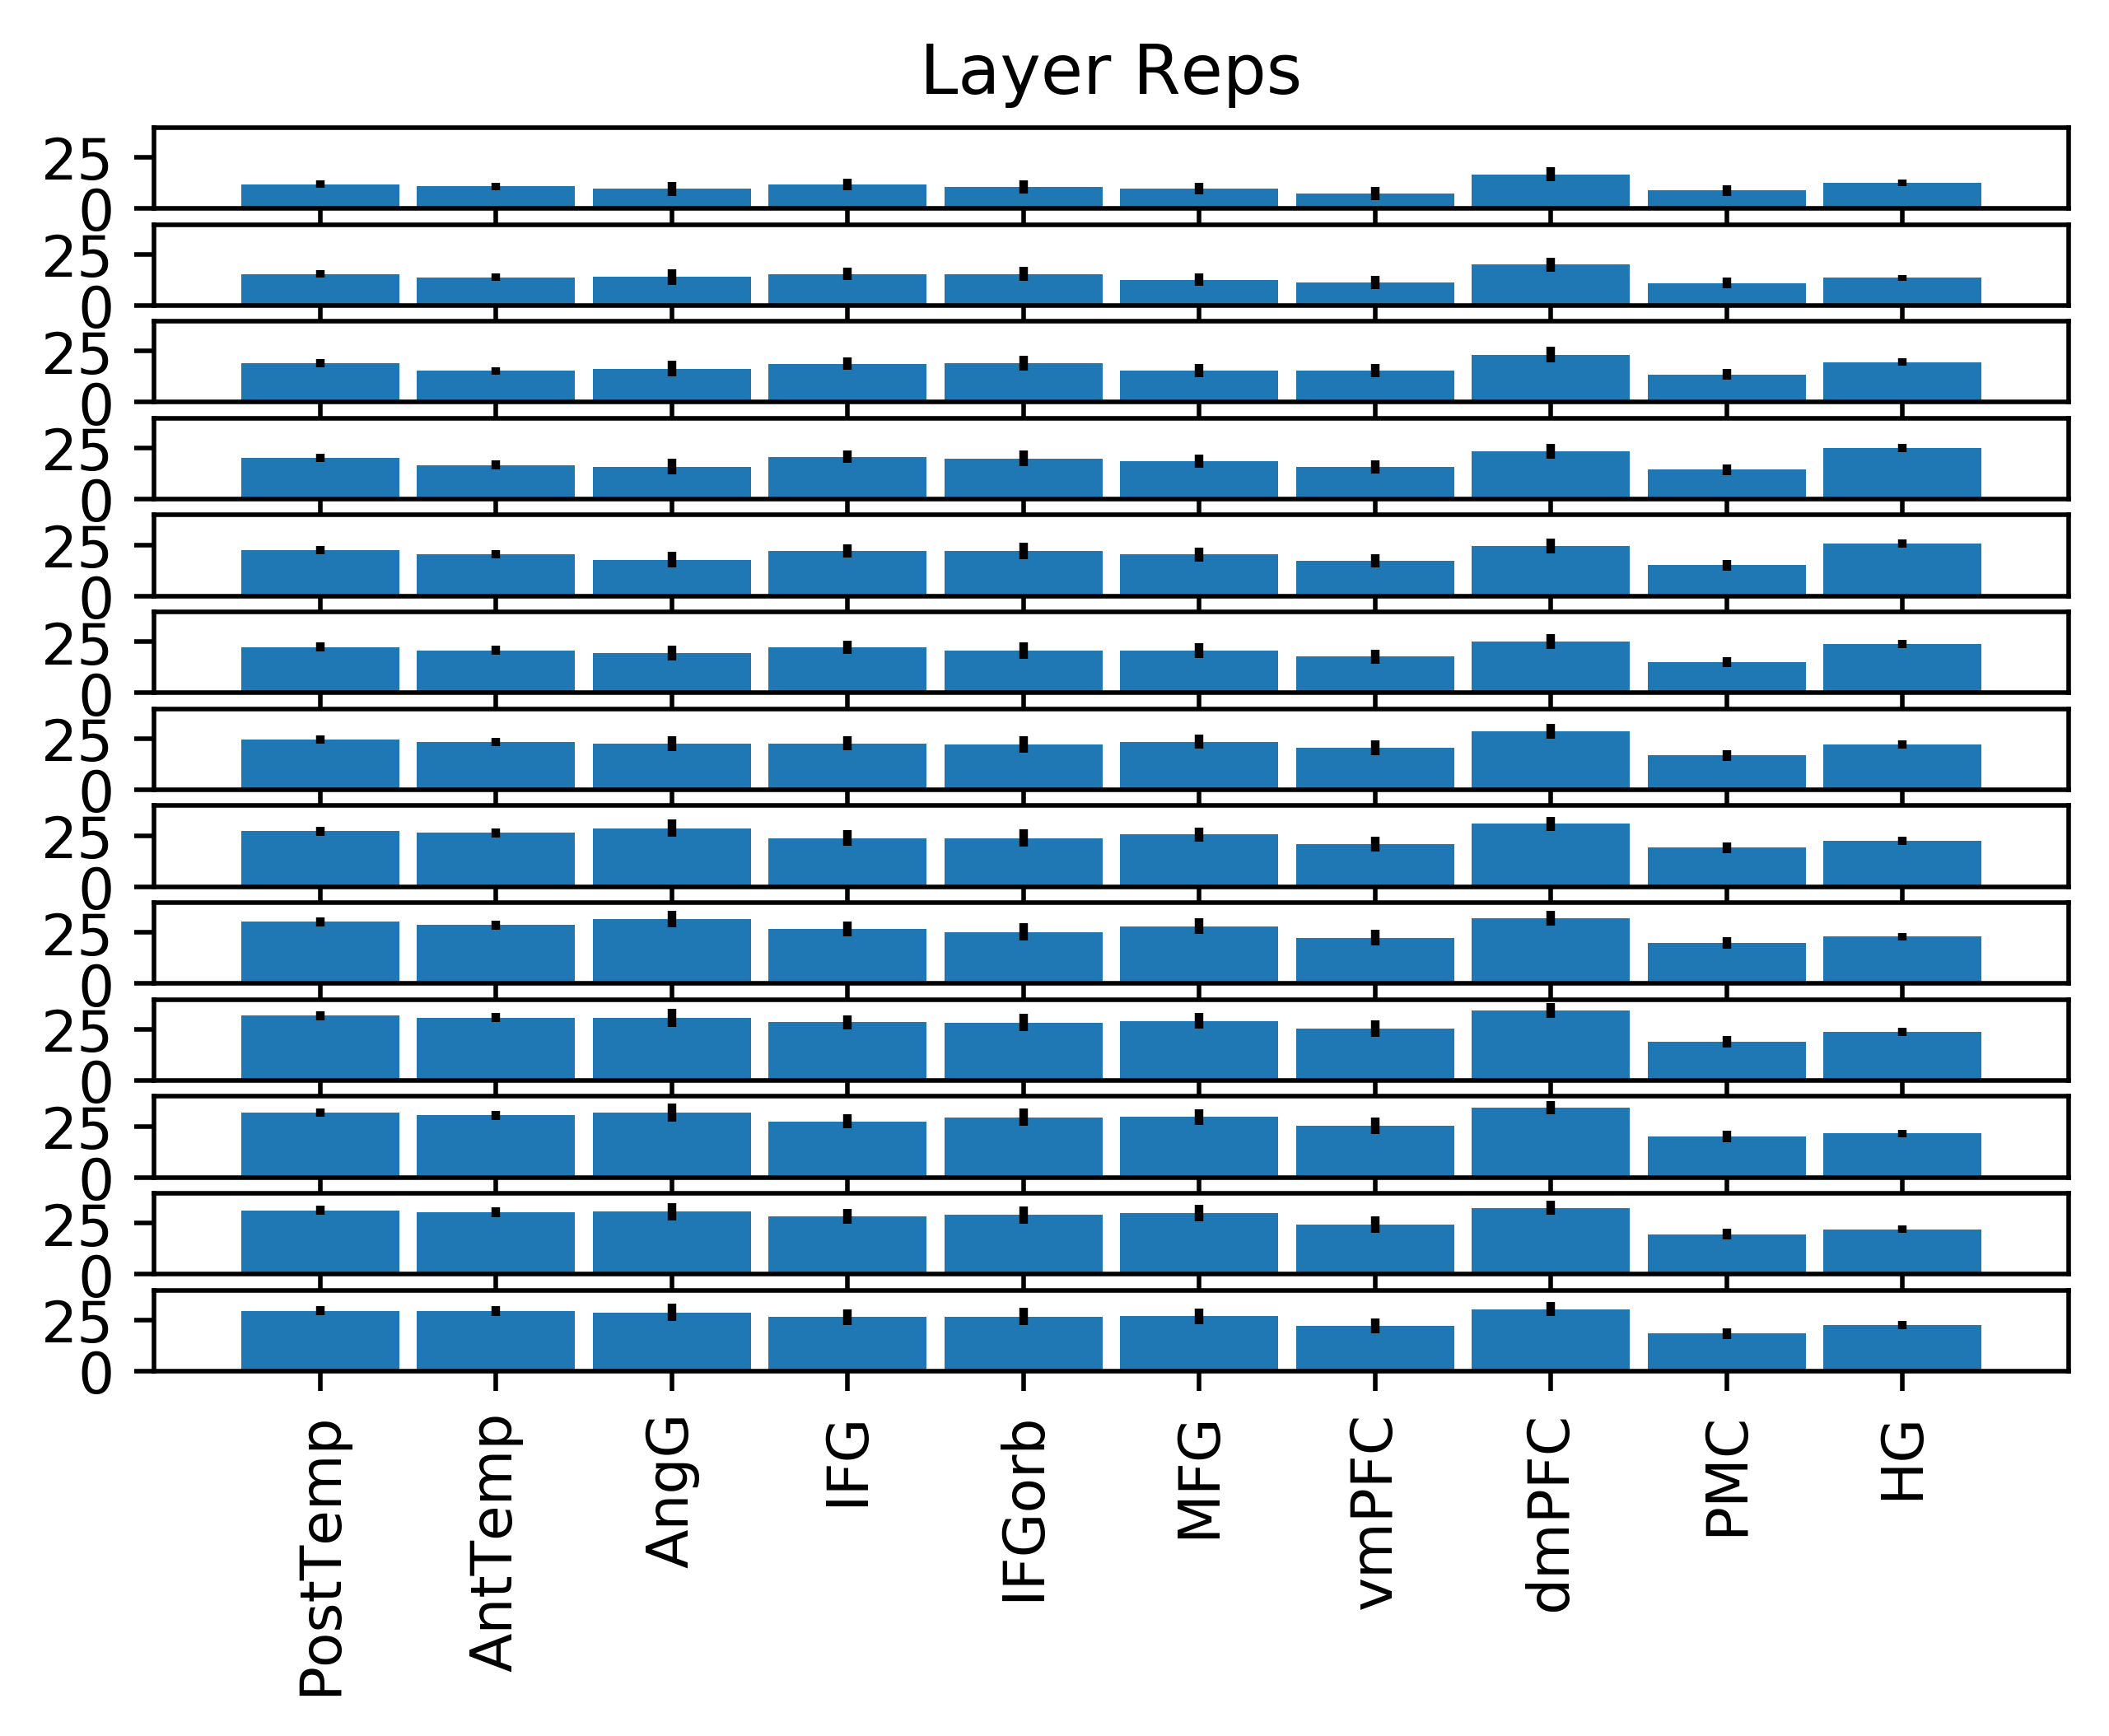

In [46]:
z_reps=['layer_'+str(i)+"_z_representations" for i in range(12)]
layer_reps=['layer_'+str(i)+"_activations" for i in range(13)]
layer_reps_mat=np.asarray([get_result_dataset(['black','slumlordreach'],layer_reps[i],normalize_isc=True) for i in range(13)]).mean(axis=1)
errors=np.asarray([get_result_dataset(['black','slumlordreach'],layer_reps[i],normalize_isc=True) for i in range(13)]).std(axis=1)/np.sqrt(63)
print(layer_reps_mat.shape)
layer_reps_mat=np.asarray([layer_reps_mat[:,:10],layer_reps_mat[:,10:]]).mean(axis=0)
errors=np.asarray([errors[:,:10],errors[:,10:]]).mean(axis=0)
fig,axarr=plt.subplots(nrows=13,sharex=True,sharey=True,dpi=500)
for i in range(13):
    axarr[i].bar(list(range(10)),layer_reps_mat[i],width=0.9,yerr=errors[i])
    axarr[i].set_xticks(list(range(10)))
    axarr[i].set_xticklabels(rois,rotation=90)
    #axarr[i].set_yticklabels([])
    #axarr[i].set_title(rois[i])
#fig.tight_layout()
axarr[0].set_title("Layer Reps")

/usr/people/sreejank/anaconda3/envs/fmri/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
(12, 20)


Text(0.5, 1.0, 'Z Reps')

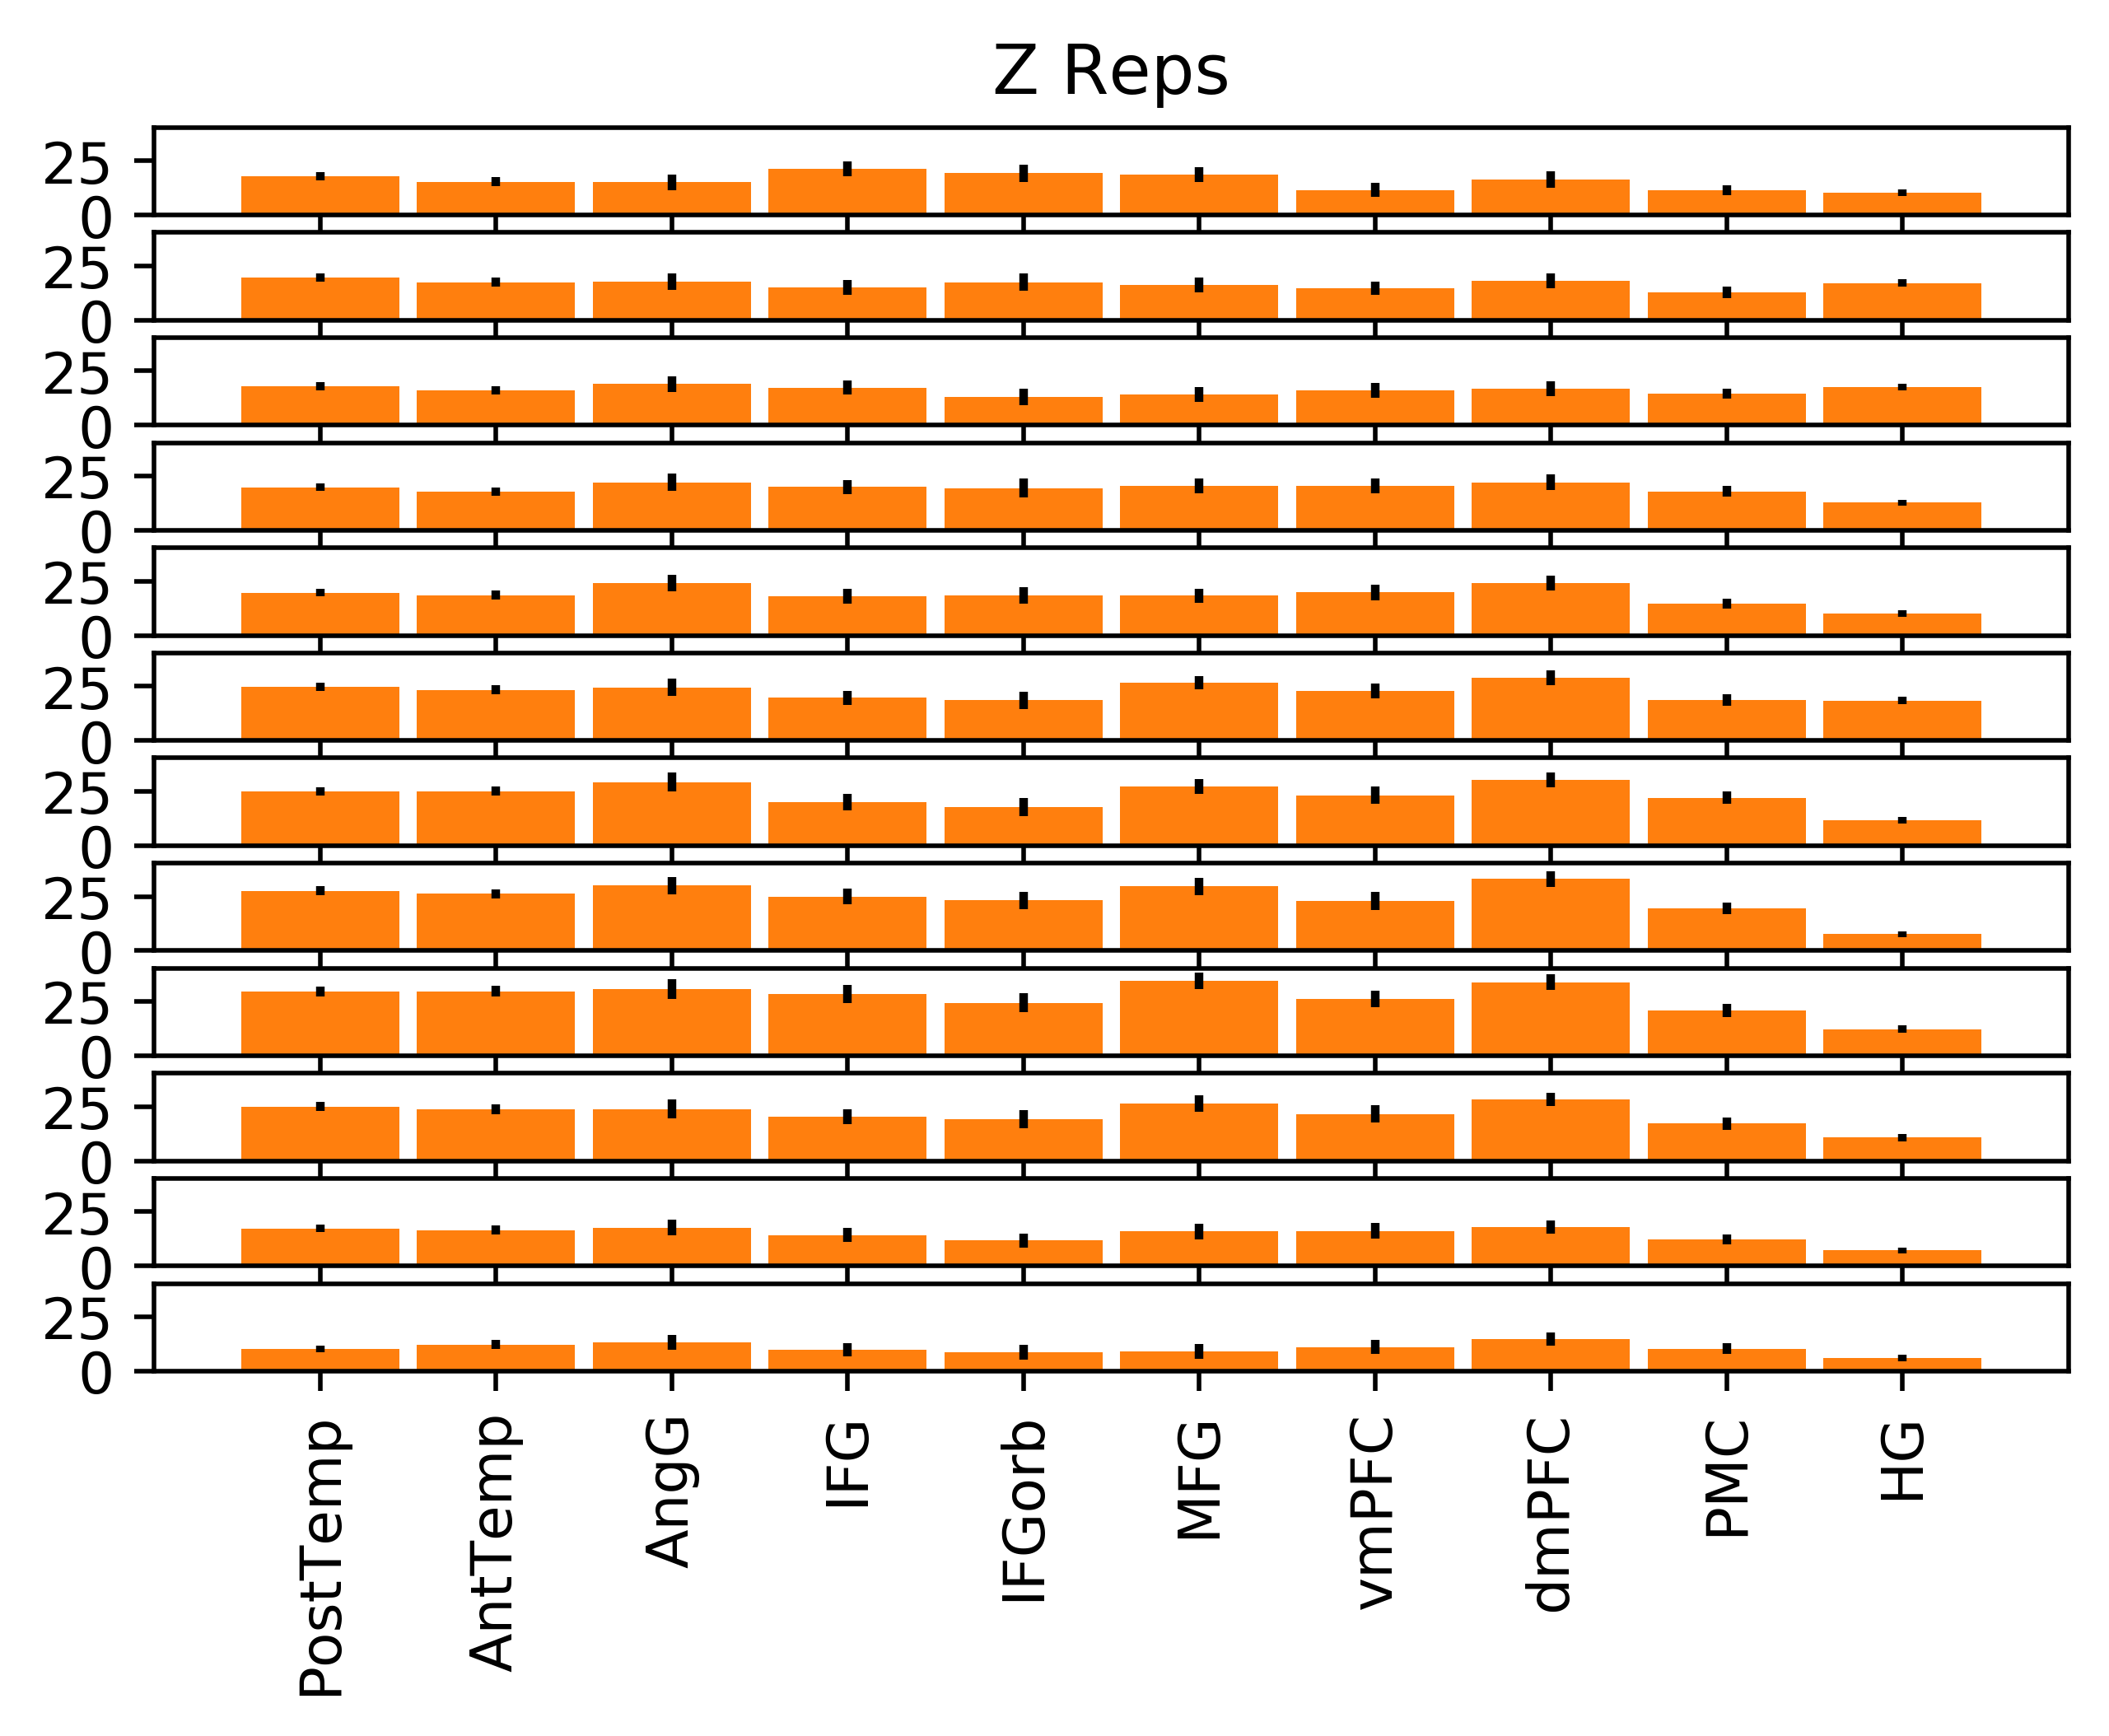

In [47]:
z_reps=['layer_'+str(i)+"_z_representations" for i in range(12)]
layer_reps=['layer_'+str(i)+"_activations" for i in range(13)]
layer_reps_mat=np.asarray([get_result_dataset(['black','slumlordreach'],z_reps[i],normalize_isc=True) for i in range(12)]).mean(axis=1)
errors=np.asarray([get_result_dataset(['black','slumlordreach'],z_reps[i],normalize_isc=True) for i in range(12)]).std(axis=1)/np.sqrt(63)
print(layer_reps_mat.shape)
layer_reps_mat=np.asarray([layer_reps_mat[:,:10],layer_reps_mat[:,10:]]).mean(axis=0)
errors=np.asarray([errors[:,:10],errors[:,10:]]).mean(axis=0)
fig,axarr=plt.subplots(nrows=12,sharex=True,sharey=True,dpi=500)
for i in range(12):
    axarr[i].bar(list(range(10)),layer_reps_mat[i],width=0.9,yerr=errors[i],color='C1')
    axarr[i].set_xticks(list(range(10)))
    axarr[i].set_xticklabels(rois,rotation=90)
    #axarr[i].set_yticklabels([])
    #axarr[i].set_title(rois[i])
#fig.tight_layout()
axarr[0].set_title("Z Reps")